# library import 

In [1]:
import cv2
import os,re,sys
import numpy as np
import tensorflow as tf
#import tensorflow.contrib.eager as tfe

from glob import glob
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# tensorflow eager mode enable 

In [2]:
#tfe.enable_eager_execution()

In [3]:
flist = glob('./train_set/*.jpg')

In [4]:
def get_img(f):
    img_file = tf.read_file(f)
    img = tf.cast( tf.image.decode_jpeg(img_file,channels=1), dtype=tf.float32)
    tokens = tf.string_split([f],delimiter='/').values
    label_num = tf.string_to_number(tf.substr(tokens[-1],1,1))
    label_int = tf.cast(label_num,tf.int32)
    label_onehot = tf.one_hot(label_int,4)
    return (img,label_onehot)

In [5]:
data = tf.data.Dataset.from_tensor_slices(flist)
data = data.map(get_img).repeat(20).batch(2)
batch = data.make_one_shot_iterator().get_next()

In [6]:
sample_img = cv2.imread(flist[0],cv2.IMREAD_GRAYSCALE)

In [7]:
plt.imshow(sample_img,cmap='gray')

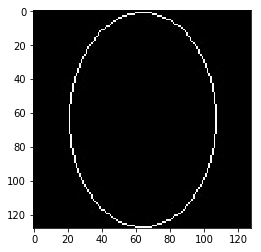

In [8]:
plt.show()

In [12]:

tf.reset_default_graph()
class simple_builder(object):
    
    train_mode = True
    init1d = tf.contrib.layers.xavier_initializer
    init2d = tf.contrib.layers.xavier_initializer_conv2d
    
    def _get_img(self,path):
        img_file = tf.read_file(path)
        img = tf.cast( tf.image.decode_jpeg(img_file,channels=1), dtype=tf.float32)
        tokens = tf.string_split([path],delimiter='/').values
        label_num = tf.string_to_number(tf.substr(tokens[-1],1,1))
        label_int = tf.cast(label_num,tf.int32)
        label_onehot = tf.one_hot(label_int,4)
        return (img,label_onehot)
    
    def _make_pipeline(self,path):
        flist = glob(path+os.path.sep+'*.jpg')
        data = tf.data.Dataset.from_tensor_slices(flist)
        data = data.map(self._get_img).repeat().batch(20)
        return data
    
    def __init__(self):
        test_set = self._make_pipeline('./test_set')
        train_set = self._make_pipeline('./train_set')
        iterator = tf.data.Iterator.from_structure(\
                            train_set.output_types,\
                            train_set.output_shapes)
        
        (self.images, self.labels) = iterator.get_next()
        
        self.test_set = iterator.make_initializer(test_set)
        self.train_set = iterator.make_initializer(train_set)
        
        
        
    
    def build(self, train_mode=True, kprob=0.8):
            
        # intput 128,128,1
        
        conv1 = self.conv_layer(self.images, 16, 'conv1', 3, train_mode,kprob )
        conv2 = self.conv_layer(conv1, 16, 'conv2' )

        # pooling 64,64, ,16
        pool1 = tf.nn.max_pool(conv2,ksize=[1,2,2,1], strides=[1,2,2,1] , padding='SAME')

        conv3 = self.conv_layer(pool1, 64, 'conv3', 3, train_mode,kprob )
        conv4 = self.conv_layer(conv3, 64, 'conv4', 3, train_mode,kprob )
        
        # pooling 32,32,64
        pool2 = tf.nn.max_pool(conv4,ksize=[1,2,2,1], strides=[1,2,2,1] , padding='SAME')
        
        conv5 = self.conv_layer(pool2, 64, 'conv5', 3, train_mode,kprob )
        
        # pooling 16,16,64
        pool3 = tf.nn.max_pool(conv4,ksize=[1,2,2,1], strides=[1,2,2,1] , padding='SAME')
        
        conv6 = self.conv_layer(pool2, 64, 'conv6', 3, train_mode,kprob )
        
        # pooling 8,8,64
        pool4 = tf.nn.max_pool(conv6,ksize=[1,2,2,1], strides=[1,2,2,1] , padding='SAME')
        pool4 = tf.reshape(pool4,[-1, 8*8*64])
        
        fc1 = self.fc_layer(pool4, 512, 'fc1',kprob)
        fc2 = self.fc_layer(fc1, 64, 'fc2',kprob)
        logits = self.fc_layer(fc2, 5, 'fc3',kprob,True)
        
        return logits
        
    
    
    def conv_layer(self,datas ,filters, name , ksize=3, train_mode=True, kprob=0.8):
        
        with tf.variable_scope(name) :
            nformat = name + '_{}'
            shapes = datas.get_shape().as_list()  
            k_shape = [ksize, ksize, shapes[3], filters]

            weight  = tf.get_variable(nformat.format('w1'),shape=k_shape,initializer=self.init2d())
            layer = tf.nn.conv2d(datas , weight, strides=[1,1,1,1],padding='SAME')
            layer = tf.layers.batch_normalization(layer ,training=train_mode)

            layer  = tf.nn.relu(layer)
            layer  = tf.nn.dropout(layer,keep_prob=kprob)
        
        return layer
    
    def fc_layer(self, datas, osize, name, kprob=0.8, is_logits=False):
        
        shapes = datas.get_shape().as_list()  
        
        weight = tf.get_variable(name+'w1',shape=[shapes[-1],osize], initializer=self.init1d())
        bias = tf.get_variable(name+'b1',shape=[osize], initializer=self.init1d())

        layer = tf.nn.bias_add( tf.matmul(datas, weight) , bias )
        
        if( not is_logits):
            layer = tf.nn.relu(layer)
            layer = tf.nn.dropout(layer, kprob)
            
        return layer    

       
    def loss_score(self, logits):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=self.labels)
        cross_mean = tf.reduce_mean(cross_entropy)
        return cross_mean
    
    def train_operator(self,loss,lr=0.001):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = tf.train.AdamOptimizer(lr).minimize(loss)
        return train_op
        
    def accuracy_socre(self, logits):
        correct_prediction = tf.equal( tf.argmax(logits,axis=1), tf.argmax(self.labels,1), axis=1 )
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy
        
        

In [13]:
builder = simple_builder()

In [14]:
model = builder.build()

In [15]:
train_loss = builder.loss_score(logits=model)
train_operator = builder.train_operator(loss=train_loss)

In [16]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    sess.run(builder.train_set)
    rst = sess.run(train_loss)

InvalidArgumentError: logits and labels must be broadcastable: logits_size=[80,5] labels_size=[20,4]
	 [[Node: softmax_cross_entropy_with_logits = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](softmax_cross_entropy_with_logits/Reshape, softmax_cross_entropy_with_logits/Reshape_1)]]

Caused by op 'softmax_cross_entropy_with_logits', defined at:
  File "/opt/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-813f136e8ec3>", line 1, in <module>
    train_loss = builder.loss_score(logits=model)
  File "<ipython-input-12-41e53c0f58b2>", line 105, in loss_score
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=self.labels)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1873, in softmax_cross_entropy_with_logits_v2
    precise_logits, labels, name=name)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 7169, in softmax_cross_entropy_with_logits
    name=name)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must be broadcastable: logits_size=[80,5] labels_size=[20,4]
	 [[Node: softmax_cross_entropy_with_logits = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](softmax_cross_entropy_with_logits/Reshape, softmax_cross_entropy_with_logits/Reshape_1)]]


In [17]:
builder.images

<tf.Tensor 'IteratorGetNext:0' shape=(?, ?, ?, 1) dtype=float32>

In [18]:
builder.labels

<tf.Tensor 'IteratorGetNext:1' shape=(?, 4) dtype=float32>

In [ ]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    sess.run(builder.test_set)
    si,sl = sess.run([builder.images,builder.])
    